# Курсовая работа
Я выбрал классификацию автомобилей по типам на изображениях, для этого я выбрал датасет Стэнфордского университета. Данный набор данных содержит 16185 изображений автомобилей в 196 классах.

# Предварительный анализ датасета

In [207]:
#Импортируем необходимые библиотеки для работы
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import time
import cv2

In [208]:
df = pd.read_csv("./anno.csv", sep=";")
df

,Image,x1,y1,x2,y2,class,test
0,000001.jpg,112,7,853,717,1,0
1,000002.jpg,48,24,441,202,1,0
2,000003.jpg,7,4,277,180,1,0
3,000004.jpg,33,50,197,150,1,0
4,000005.jpg,5,8,83,58,1,0
...,...,...,...,...,...,...,...
16180,016181.jpg,38,36,375,234,196,1
16181,016182.jpg,29,34,235,164,196,1
16182,016183.jpg,25,32,587,359,196,1
16183,016184.jpg,56,60,208,186,196,1


Смотрим на распределение данных по классам. Cтроим график по количеству элементов в каждом классе для разбалансировки классов

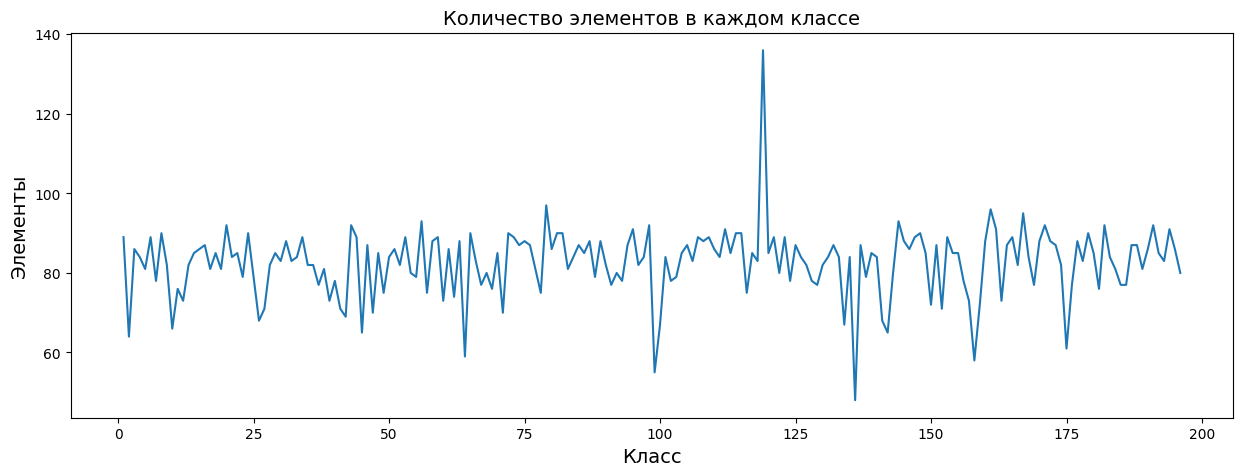

In [209]:
my_series = df.groupby("class")["Image"].count()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(my_series)
ax.set_title('Количество элементов в каждом классе', fontsize=14)
ax.set_xlabel('Класс', fontsize=14)
ax.set_ylabel('Элементы', fontsize=14)
plt.show()

Как можем заметить, классы не сбалансированы между собой

In [210]:
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

С помощью диаграммы размаха ящик с усами определяем медиану, равную 84

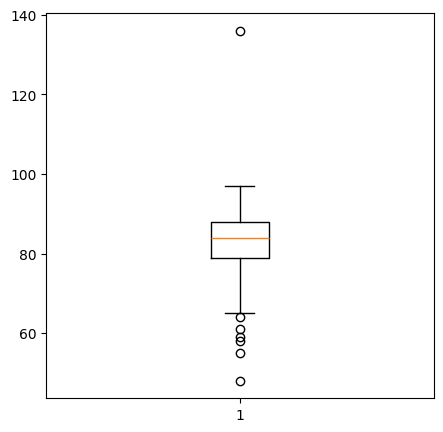

In [211]:
fig = plt.figure(figsize =(5, 5))
bp = plt.boxplot(my_series)
plt.show()

In [212]:
bp_df = get_box_plot_data(["bp"], bp)
bp_df

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,bp,65.0,78.75,84.0,88.0,97.0


# Зависимость точности от количества классов в датасете

In [213]:
classes_count_list = []
accurancy_list = []

In [214]:
row_number, column_number = 64, 64

def patchfix(path: str) -> str:
     return f"./car_images/{path}"

In [215]:
from sklearn.naive_bayes import MultinomialNB

for i in range(1, 100):
    new_series1 = my_series[my_series > i]
    min_series_count1 = min(new_series1)
    classes_set1 = set(list(new_series1.to_dict().keys()))
    df_fixed1 = pd.DataFrame()
    
    for item in classes_set1:
        buf_df = df[df["class"] == item][:min_series_count1]
        df_fixed1 = pd.concat([df_fixed1, buf_df], ignore_index=True, sort=False)
    
    files_list1 = df_fixed1["Image"].to_list()
    files_len = len(files_list1)
    CLASSES_DATA = df_fixed1["class"].to_numpy()
    IMAGES_DATA = np.zeros(shape=(files_len,row_number*column_number))
    
    for index, file in enumerate(files_list1):
        img = cv2.imread(patchfix("final/" + file), cv2.IMREAD_UNCHANGED)
        IMAGES_DATA[index] = img.flatten()
    
    IMAGES_DATA = IMAGES_DATA / 255
    X = IMAGES_DATA
    Y = CLASSES_DATA
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
    
    nb = MultinomialNB().fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    acc = metrics.classification_report(y_test, y_pred, output_dict=True)["accuracy"]
    
    classes_count_list.append(len(classes_set1))
    accurancy_list.append(acc)

c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [216]:
accurancy_list_fixed = [item *100 for item in accurancy_list]

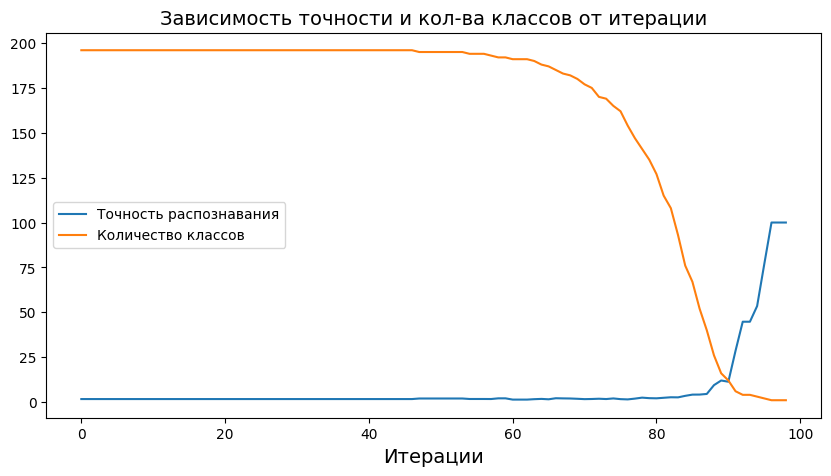

In [217]:
x = list(range(len(classes_count_list)))
y = accurancy_list_fixed
z = classes_count_list 

fig = plt.figure(figsize =(10, 5))
plt.plot(x, y, label='Точность распознавания')
plt.plot(x, z, label='Количество классов')

plt.title('Зависимость точности и кол-ва классов от итерации', fontsize=14)
plt.xlabel('Итерации', fontsize=14)

plt.legend()
plt.show()

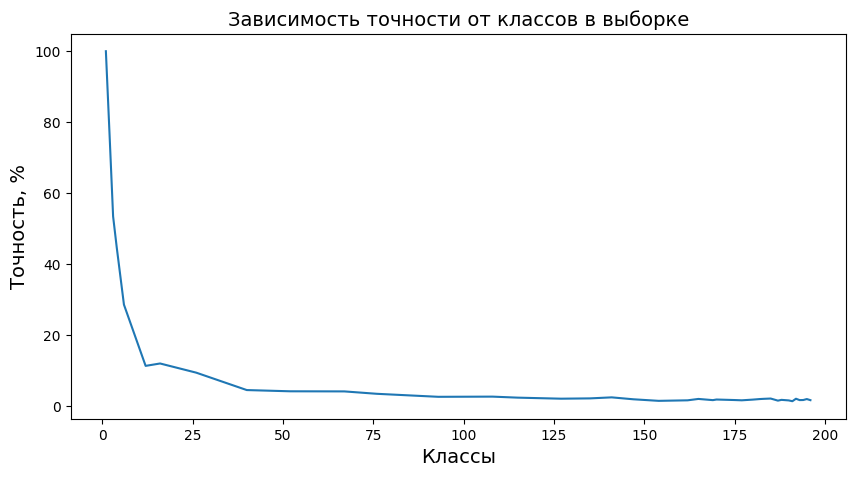

In [218]:
x = classes_count_list
y = accurancy_list_fixed

fig = plt.figure(figsize =(10, 5))
plt.plot(x, y, label='Точность распознавания')
plt.title('Зависимость точности от классов в выборке', fontsize=14)
plt.xlabel('Классы', fontsize=14)
plt.ylabel('Точность, %', fontsize=14)
plt.show()

Чтобы сбалансировать выборку, мы оставляем только 10 самых многочисленных классов и сокращаем выборку до минимального размера. Это сознательное уменьшение количества классов связано с тем, что при их увеличении точность существенно снижается. Для оценки точности был использован наивный байесовский классификатор, поскольку он является самым быстрым среди всех моделей.

In [219]:
buff_items = [(k,v) for k,v in my_series.to_dict().items()]
buff_items.sort(key=lambda x:x[1], reverse=True)
min_series_count = min([item[1] for item in buff_items[:10]])
min_series_count

92

In [220]:
new_series = my_series[my_series > min_series_count-1]
new_series

class
20      92
43      92
56      93
79      97
98      92
119    136
144     93
161     96
167     95
171     92
182     92
191     92
Name: Image, dtype: int64

Множество классов, которыке удовлетворяют условиям

In [221]:
classes_set = set(list(new_series.to_dict().keys()))
print(len(classes_set))

12


Формируем новый датасет, в который добавляем все новые классы

In [222]:
df_fixed = pd.DataFrame()

In [223]:
counter = 0
for item in classes_set:
    buf_df = df[df["class"] == item][:min_series_count]
    df_fixed = pd.concat([df_fixed, buf_df], ignore_index=True, sort=False)
    counter += 1
print(counter)

12


Заново строим график повому датаферйму df_fixed

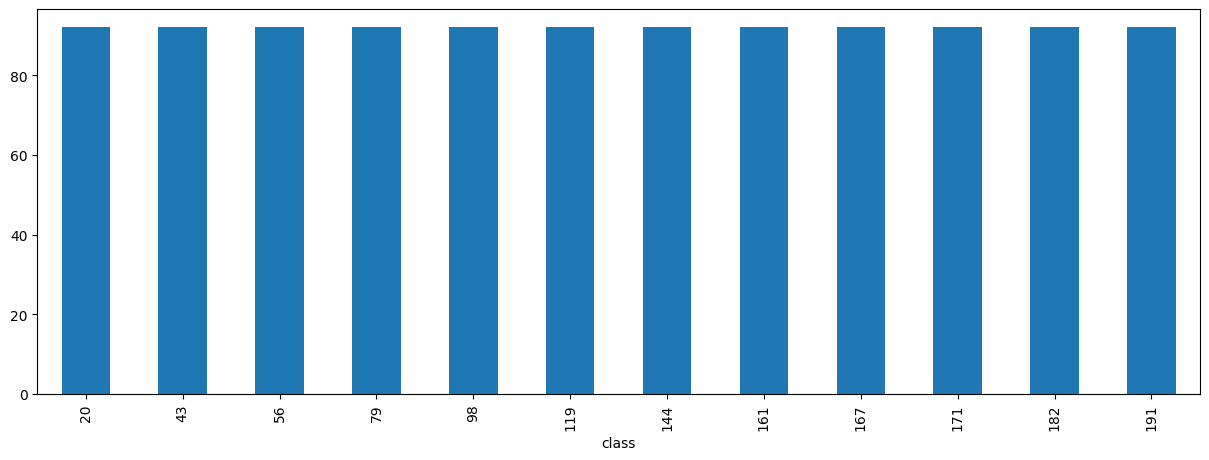

In [224]:
df_fixed.groupby("class")["Image"].count().plot(kind="bar",figsize=(15, 5))
plt.show()

Определяем список файлов, с которыми в дальнейшем будем работать

In [225]:
files_list = df_fixed["Image"].to_list()
files_len = len(files_list)
files_len

1104

Определяем список классов, которые определяют эти файлы

In [226]:
CLASSES_DATA = df_fixed["class"].to_numpy()
print(len(df_fixed["class"].to_list()))
print(len(set(df_fixed["class"].to_list())))
CLASSES_DATA

1104
12


array([161, 161, 161, ..., 191, 191, 191], dtype=int64)

# Загрузка и подготовка данных

Существует две популярные библиотеки для предварительной обработки изображений:
-	Pillow — свободная библиотека для работы с изображениями на Python с открытым исходным кодом. Она предлагает различные алгоритмы, в том числе функции для загрузки изображений из файлов и создания новых изображений. Библиотека разработана на Python и C.
-	OpenCV — это библиотека компьютерного зрения с открытым исходным кодом, предназначенная для анализа, классификации и обработки изображений. Она написана на C++, но есть оболочки для Python и Java.

In [227]:
all_files_list = df["Image"].to_list()

### 1. Переводим все изображения в формат матрицы

Чтобы начать работу с изображением RGB, нужно преобразовать его в матрицу размером NxMx3, где N — количество пикселей по вертикали, M — количество пикселей по горизонтали, а 3 — количество цветовых каналов. Для этого используется метод cv2.imread из библиотеки OpenCV, который считывает изображение и преобразует его в матрицу.

In [228]:
def show_img(index=0, path=""):
    plt.imshow(cv2.imread(patchfix(path + all_files_list[index]), cv2.IMREAD_UNCHANGED))

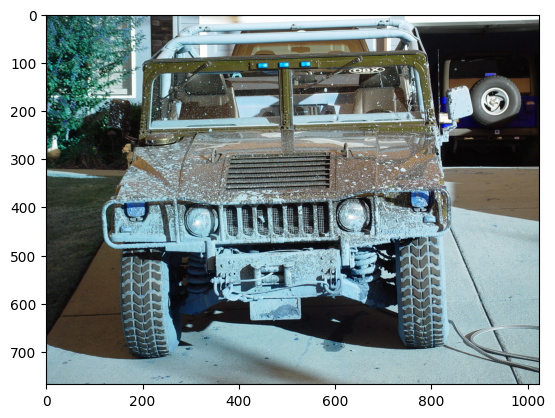

In [229]:
show_img()

### 2. Уменьшаем размеры

Так как все исходные изображения разного разрешения и соотношения сторон, то при помощи метода OpenCV cv2.resize происходит уменьшение изображения до 64 × 64 пикселя. Очевидно, что это также влияет на производительность решения в лучшую сторону

In [230]:
counter = 1
for file in all_files_list:
    img = cv2.imread(patchfix(file), cv2.IMREAD_UNCHANGED)
    resized = cv2.resize(img, (row_number, column_number), interpolation = cv2.INTER_AREA)
    resized244 = cv2.resize(img, (244, 244), interpolation = cv2.INTER_AREA)
    cv2.imwrite(patchfix("resize/" + file), resized)
    cv2.imwrite(patchfix("resize244/" + file), resized244)
    
    if counter % 100 == 0:
        print(f"{counter}/{files_len}")

    counter += 1
    
show_img(0, "resize/")

100/1104
200/1104
300/1104
400/1104
500/1104
600/1104
700/1104
800/1104
900/1104
1000/1104
1100/1104
1200/1104
1300/1104
1400/1104
1500/1104
1600/1104
1700/1104
1800/1104
1900/1104
2000/1104
2100/1104
2200/1104
2300/1104
2400/1104
2500/1104
2600/1104
2700/1104
2800/1104
2900/1104
3000/1104
3100/1104
3200/1104
3300/1104
3400/1104
3500/1104
3600/1104
3700/1104
3800/1104
3900/1104
4000/1104
4100/1104
4200/1104
4300/1104
4400/1104
4500/1104
4600/1104
4700/1104
4800/1104
4900/1104
5000/1104
5100/1104
5200/1104
5300/1104
5400/1104
5500/1104
5600/1104
5700/1104
5800/1104
5900/1104
6000/1104
6100/1104
6200/1104
6300/1104
6400/1104
6500/1104
6600/1104
6700/1104
6800/1104


KeyboardInterrupt: 

### 3. Переводим в черно-белый формат

Для большинства алгоритмов обработки изображений требуется перевод исходных данных в монохромный режим т.е. в преобразование в черно-белый формат. Это необходимо в целях уменьшения каналов изображения с 3 (для RGB) до 1. Как следствие, каждый пиксель на изображении кодируется всего одним значением от 0 до 255.

100/1104
200/1104
300/1104
400/1104
500/1104
600/1104
700/1104
800/1104
900/1104
1000/1104
1100/1104
1200/1104
1300/1104
1400/1104
1500/1104
1600/1104
1700/1104
1800/1104
1900/1104
2000/1104
2100/1104
2200/1104
2300/1104
2400/1104
2500/1104
2600/1104
2700/1104
2800/1104
2900/1104
3000/1104
3100/1104
3200/1104
3300/1104
3400/1104
3500/1104
3600/1104
3700/1104
3800/1104
3900/1104
4000/1104
4100/1104
4200/1104
4300/1104
4400/1104
4500/1104
4600/1104
4700/1104
4800/1104
4900/1104
5000/1104
5100/1104
5200/1104
5300/1104
5400/1104
5500/1104
5600/1104
5700/1104
5800/1104
5900/1104
6000/1104
6100/1104
6200/1104
6300/1104
6400/1104
6500/1104
6600/1104
6700/1104
6800/1104
6900/1104
7000/1104
7100/1104
7200/1104
7300/1104
7400/1104
7500/1104
7600/1104
7700/1104
7800/1104
7900/1104
8000/1104
8100/1104
8200/1104
8300/1104
8400/1104
8500/1104
8600/1104
8700/1104
8800/1104
8900/1104
9000/1104
9100/1104
9200/1104
9300/1104
9400/1104
9500/1104
9600/1104
9700/1104
9800/1104
9900/1104
10000/1104
10100/11

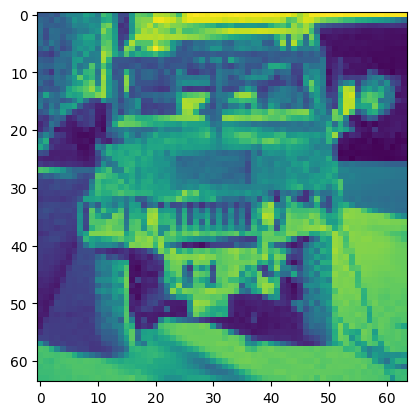

In [ ]:
counter = 1
for file in all_files_list:
    img = cv2.imread(patchfix("resize/" + file),cv2.IMREAD_UNCHANGED)

    
    #Если это RGB - конвертим
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    cv2.imwrite(patchfix("final/" + file), img) 
    
    if counter % 100 == 0:
        print(f"{counter}/{files_len}")
    
    counter += 1
    
show_img(0, "final/")

### 4. Формирование факторов

In [232]:
IMAGES_DATA = np.zeros(shape=(files_len,row_number*column_number))
IMAGES_DATA.shape

(1104, 4096)

In [233]:
IMAGES_DATA

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [234]:
files_len = len(files_list)
for index, file in enumerate(files_list):
    img = cv2.imread(patchfix("final/" + file),cv2.IMREAD_UNCHANGED)
    IMAGES_DATA[index] = img.flatten()

In [235]:
IMAGES_DATA

array([[ 38.,  55.,  57., ..., 161., 163., 159.],
       [216., 217., 217., ..., 163., 158., 153.],
       [120.,  95.,  83., ..., 134., 133., 132.],
       ...,
       [173., 176., 152., ..., 161., 173., 143.],
       [231., 231., 230., ..., 107., 107., 111.],
       [ 50.,  99., 119., ..., 173., 172., 172.]])

Нормализация матриц

Для большинства методов машинного обучения требуются нормализованные значения, т.е. значения в диапазоне от 0 до 1. Наиболее распространенной нормализацией изображения является метод максимальной и минимальной нормализации

In [236]:
IMAGES_DATA = IMAGES_DATA / 255
IMAGES_DATA

array([[0.14901961, 0.21568627, 0.22352941, ..., 0.63137255, 0.63921569,
        0.62352941],
       [0.84705882, 0.85098039, 0.85098039, ..., 0.63921569, 0.61960784,
        0.6       ],
       [0.47058824, 0.37254902, 0.3254902 , ..., 0.5254902 , 0.52156863,
        0.51764706],
       ...,
       [0.67843137, 0.69019608, 0.59607843, ..., 0.63137255, 0.67843137,
        0.56078431],
       [0.90588235, 0.90588235, 0.90196078, ..., 0.41960784, 0.41960784,
        0.43529412],
       [0.19607843, 0.38823529, 0.46666667, ..., 0.67843137, 0.6745098 ,
        0.6745098 ]])

## Работа в sklearn

Делим данные на тестовую и обучающую выборки. Выборки делим в соотношении 80% на 20% с помощью метода scikit-learn train_test_split

In [237]:
assert IMAGES_DATA.shape[0] == CLASSES_DATA.shape[0]

In [238]:
X = IMAGES_DATA
Y = CLASSES_DATA

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

# Машина опорных векторов
Машина опорных векторов SVM является универсальным решением в задачах классификации, наравне с нейронной сетью и бустингом.
Метод опорных векторов обладает особым свойством, заключающимся в том, что он постоянно уменьшает эмпирическую ошибку классификации, увеличивая разрыв, поэтому его также называют методом классификатора с максимальным разрывом.


In [240]:
from sklearn import svm

start_time = time.time()
nb = svm.SVC(max_iter=5000).fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          20       0.40      0.21      0.28        19
          43       0.12      0.17      0.14        18
          56       0.30      0.33      0.32        18
          79       0.33      0.26      0.29        19
          98       0.07      0.06      0.06        18
         119       0.43      0.47      0.45        19
         144       0.11      0.11      0.11        18
         161       0.00      0.00      0.00        19
         167       0.07      0.06      0.06        18
         171       0.00      0.00      0.00        19
         182       0.00      0.00      0.00        18
         191       0.16      0.28      0.20        18

    accuracy                           0.16       221
   macro avg       0.17      0.16      0.16       221
weighted avg       0.17      0.16      0.16       221

Время выполнения 1.2642605304718018


# Метод Байеса
Наивный байесовский классификатор является одним из наиболее простых и быстрых алгоритмов машинного обучения, который используется в качестве базового достаточно часто, причем достаточно часто даёт хорошие показатели метрик в задачах классификации.
Наивным алгоритм называют прежде всего из-за того, что по определению он считает каждый фактор равнозначным. Например, при изображении разрешением 64×64 каждый из 4096 пикселей будет влиять на результат равнозначно, что не совсем так. Достаточно часто исходный объект на изображении находится ближе к центру, при этом слева и справа будут также располагаться пиксели, которые не относятся к нему.


In [241]:
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()
nb = MultinomialNB().fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          20       0.27      0.16      0.20        19
          43       0.00      0.00      0.00        18
          56       0.13      0.11      0.12        18
          79       0.22      0.26      0.24        19
          98       0.00      0.00      0.00        18
         119       0.29      0.21      0.24        19
         144       0.03      0.06      0.04        18
         161       0.09      0.05      0.07        19
         167       0.12      0.06      0.08        18
         171       0.09      0.21      0.13        19
         182       0.05      0.06      0.05        18
         191       0.12      0.17      0.14        18

    accuracy                           0.11       221
   macro avg       0.12      0.11      0.11       221
weighted avg       0.12      0.11      0.11       221

Время выполнения 0.032631635665893555


# Метод k-ближайших соседей 
Алгоритм k-ближайших соседей, также известный как KNN, является непараметрическим классификатором контролируемого обучения, который использует близость для классификации или прогнозирования группировки отдельных точек данных. Обычно он применяется в качестве алгоритма классификации, исходя из предположения, что похожие объекты могут быть найдены рядом друг с другом.
Метод достаточно прост: для каждого объекта происходит сравнение со всеми другими объектами в выборке и путем нахождения косинуса угла между векторами вычисляется расстояние между ними. Затем определяется аргумент k, который в обучающей выборке определяет количество ближайших объектов для текущего элемента b. Далее элемент заносят в тот класс, у которого релевантность выше заданного порога.

In [242]:
import sklearn.neighbors as neigh

start_time = time.time()
kn = neigh.KNeighborsClassifier(n_neighbors=90, n_jobs=6).fit(X_train,y_train)
y_pred = kn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          20       0.33      0.21      0.26        19
          43       0.22      0.11      0.15        18
          56       0.13      0.33      0.19        18
          79       0.12      0.21      0.16        19
          98       0.00      0.00      0.00        18
         119       0.60      0.16      0.25        19
         144       0.00      0.00      0.00        18
         161       0.11      0.11      0.11        19
         167       0.05      0.06      0.05        18
         171       0.00      0.00      0.00        19
         182       0.08      0.06      0.07        18
         191       0.19      0.44      0.26        18

    accuracy                           0.14       221
   macro avg       0.15      0.14      0.12       221
weighted avg       0.15      0.14      0.12       221

Время выполнения 0.07261323928833008


c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Линейный метод SVM
В случае линейной классификации основная идея SVM заключается в поиске гиперплоскости или линии, разделяющей классы наилучшим образом, а расположенные ближе всего к разделяющей гиперплоскости образцы называются опорными векторами. Лучшим разделением классов будет то, при котором максимизируется расстояние между опорными векторами и разделяющей гиперплоскостью.

In [243]:
import sklearn.svm as svm

start_time = time.time()
svect = svm.LinearSVC(max_iter=5000).fit(X_train, y_train)
y_pred = svect.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

          20       0.10      0.11      0.10        19
          43       0.18      0.17      0.17        18
          56       0.15      0.22      0.18        18
          79       0.00      0.00      0.00        19
          98       0.18      0.11      0.14        18
         119       0.15      0.21      0.17        19
         144       0.00      0.00      0.00        18
         161       0.50      0.05      0.10        19
         167       0.00      0.00      0.00        18
         171       0.04      0.05      0.04        19
         182       0.06      0.06      0.06        18
         191       0.17      0.22      0.19        18

    accuracy                           0.10       221
   macro avg       0.13      0.10      0.10       221
weighted avg       0.13      0.10      0.10       221

Время выполнения 52.15770483016968


# Логистическая регрессия
Логистическая регрессия – алгоритм контролируемого обучения, используемый для прогнозирования зависимой категориальной целевой переменной.
Логистическая регрессия требует, чтобы зависимая переменная была категориальной. Алгоритм основывается на вероятностях принадлежности данных к определённому классу, которые моделируются с помощью логистической функции, которая выступает кумулятивной функцией распределения. Задача с непрерывным результатом, например, прогнозирование цены акции или запаса топлива в генераторе не подходит для использования логистической регрессии, для задач классификации ее использование возможно.


In [244]:
from sklearn.linear_model import LogisticRegression

start_time = time.time()
logr = LogisticRegression(max_iter=5000, n_jobs=6).fit(X_train, y_train)
y_pred = logr.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          20       0.20      0.21      0.21        19
          43       0.00      0.00      0.00        18
          56       0.17      0.17      0.17        18
          79       0.11      0.11      0.11        19
          98       0.17      0.11      0.13        18
         119       0.35      0.42      0.38        19
         144       0.06      0.06      0.06        18
         161       0.10      0.05      0.07        19
         167       0.09      0.11      0.10        18
         171       0.05      0.05      0.05        19
         182       0.07      0.06      0.06        18
         191       0.25      0.39      0.30        18

    accuracy                           0.14       221
   macro avg       0.13      0.14      0.14       221
weighted avg       0.13      0.14      0.14       221

Время выполнения 10.014360666275024


# Метод «Cлучайного леса»
Случайный лес (Random forest) – это алгоритм контролируемого машинного обучения, который широко используется в задачах классификации и регрессии. Он строит деревья решений на различных выборках и принимает их большинство голосов для классификации и среднее значение в случае регрессии.
Одной из наиболее важных особенностей алгоритма Random Forest является то, что он может обрабатывать набор данных, содержащих непрерывные переменные, как в случае регрессии, и категориальные переменные, как в случае классификации. Он показывает лучшие результаты при решении задач классификации.

Шаги, выполняемые в алгоритме random forest:
1.	В алгоритме Random Forest из набора данных, содержащего k записей, берется n случайных записей.
2.	Для каждой выборки строятся отдельные деревья решений.
3.	Каждое дерево решений генерирует выход.
4.	Окончательный результат считается на основе голосования по большинству или усреднения для классификации и регрессии соответственно.

Важные особенности случайного леса:
1.	Разнообразие – не все атрибуты/переменные/характеристики учитываются при составлении индивидуального дерева, каждое дерево отличается от другого.
2.	Невосприимчивость к размерности т.к. каждое дерево не учитывает все признаки, пространство признаков сокращается.
3.	Распараллеливание – каждое дерево создается независимо из различных данных и признаков. Это означает, что мы можем полностью использовать центральный процессор для построения случайных лесов.

In [245]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

start_time = time.time()
max_depth = [1,5,10,50]
n_estimators = [5,10,100,500]
grid_params ={'max_depth':max_depth,'n_estimators':n_estimators}
rf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), grid_params,
                  scoring = 'accuracy', cv=10, n_jobs=6, return_train_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          20       0.71      0.26      0.38        19
          43       0.22      0.22      0.22        18
          56       0.22      0.28      0.24        18
          79       0.19      0.16      0.17        19
          98       0.00      0.00      0.00        18
         119       0.39      0.37      0.38        19
         144       0.13      0.17      0.15        18
         161       0.00      0.00      0.00        19
         167       0.12      0.11      0.12        18
         171       0.05      0.05      0.05        19
         182       0.12      0.11      0.11        18
         191       0.13      0.22      0.16        18

    accuracy                           0.16       221
   macro avg       0.19      0.16      0.17       221
weighted avg       0.19      0.16      0.17       221

Время выполнения 104.07258582115173


# Линейный классификатор с SGD-обучением
Алгоритмы классификации, основанные на линейных разделяющих поверхностях, называются линейными классификаторами. Гиперплоскость делит пространство признаков на два полупространства в случае двух классов. Когда классов больше, разделяющая поверхность является кусочно-линейной.
Этот классификатор реализует регуляризованные линейные модели со стохастическим градиентным спуском (SGD): градиент потерь оценивается по каждой выборке за раз и модель обновляется по пути с уменьшающей скоростью обучения. Для достижения наилучших результатов данные должны иметь нулевое среднее и единичную дисперсию.
Эта реализация работает с данными, представленными в виде плотных или разреженных массивов данных с плавающей запятой для признаков. Модель, которую она подбирает, можно контролировать с помощью параметра потерь, по умолчанию идет подбор с помощью машины опорных векторов (SVM).


In [246]:
import math
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

start_time = time.time()
alpha = [10**x for x in range(-4,4)]
penalty = ["l1","l2"]
grid_params ={'alpha':alpha,'penalty':penalty}
alpha_log = [math.log(x,10) for x in grid_params["alpha"]]

sgd = GridSearchCV(SGDClassifier(class_weight= 'balanced'), grid_params, scoring = 'accuracy', cv=10, n_jobs=6, return_train_score=True)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

          20       0.25      0.05      0.09        19
          43       0.50      0.06      0.10        18
          56       0.00      0.00      0.00        18
          79       0.29      0.11      0.15        19
          98       0.50      0.06      0.10        18
         119       0.05      0.11      0.07        19
         144       0.11      0.11      0.11        18
         161       0.06      0.16      0.08        19
         167       0.00      0.00      0.00        18
         171       0.00      0.00      0.00        19
         182       0.00      0.00      0.00        18
         191       0.08      0.39      0.14        18

    accuracy                           0.09       221
   macro avg       0.15      0.09      0.07       221
weighted avg       0.15      0.09      0.07       221

Время выполнения 42.20707130432129


c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Свёрточная нейронная сеть (CNN)

Сверточная нейронная сеть CNN – это один из видов искусственных нейронных сетей. Нацеленная на эффективное распознавание образов, входит в состав технологий глубокого обучения и наиболее предпочтительна на сегодняшний день. В отличии от ANN, не требует большого количества эпох и уже при 10 эпохах способна выдавать результаты, аналогичные 200 эпохам в ANN или даже выше.
CNN улавливает пространственные особенности изображения. Пространственные особенности относятся к расположению пикселей и взаимосвязи между ними на изображении. Они помогают точно идентифицировать объект, определить его местоположение, а также его связь с другими объектами на изображении. CNN также следует концепции разделения параметров. Один фильтр применяется к различным частям входного сигнала для создания карты характеристик.


In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

In [248]:
files_list = df_fixed["Image"].to_list()
files_len = len(files_list)
CLASSES = df_fixed["class"].to_list()
IMAGES = np.zeros(shape=(files_len, 244*244*3))

for index, file in enumerate(files_list):
        img = cv2.imread(patchfix("resize244/" + file), cv2.IMREAD_COLOR)
        IMAGES[index] = img.flatten()
        
IMAGES = IMAGES.reshape(files_len, 244, 244, 3)
IMAGES = IMAGES / 255
X = IMAGES.astype('float32')
Y = np.eye(len(CLASSES))[list(CLASSES)]

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [250]:
model = Sequential(name="Alexnet")
model.add(Conv2D(filters= 96, kernel_size= (11,11), strides=(4,4), padding='valid', kernel_regularizer=l2(0.0005),
input_shape = (227,227,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3,3), strides= (2,2), padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(Flatten())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = len(Y), activation = 'softmax'))
model.summary()

c:\Users\artem\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Alexnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 27, 27, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 62,809,936 (239.60 MB)

 Trainable params: 62,807,184 (239.59 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [251]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))
optimizer = SGD()

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [252]:
start_time = time.time()

history = model.fit(X_train, y_train, batch_size=32, epochs=12, validation_data=(X_test, y_test),
    verbose=0, callbacks=[reduce_lr])

print("Время выполнения", (time.time()-start_time))

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
rounded_labels = np.argmax(y_test, axis=1)

print(metrics.classification_report(rounded_labels, y_pred_classes))

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

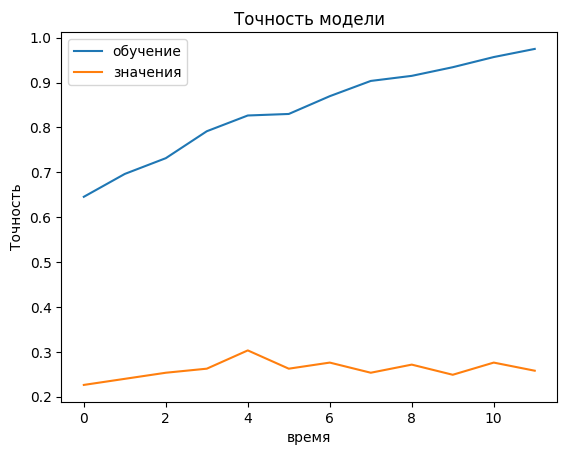

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('время')
plt.legend(['обучение', 'значения'], loc='upper left')
plt.show()

Лучше всего с задачей по классификации исходных данных справились модели, основанные на машине опорных векторов и случайного леса, но последняя отрабатывает в 3,2 раза дольше, что для большого количества данных критично, поэтому наилучшим вариантом будет метод опорных векторов, если важна именно точность. Стоит учитывать лишь относительную точность между алгоритмами по определенной выборке. т.к. при уменьшении количества классов абсолютная точность возрастает. Если же при работе нам необходима максимальная скорость обработки данных, то следует использовать наивный байесовский алгоритм, где время не превышало полсекунды. Если же мы говорим об алгоритмах глубокого обучения, то они действительно являются наилучшими на сегодняшний день, особенно отличается решение на базе сверточных нейронных сетей, где процент распознавания 70%, а обучение занимает всего 3 минуты 9 секунд. 
